using System;
using System.Collections.Generic;
using System.Linq;
using UtilityEngine;

public static class NumberExtensions{
    public static bool Approx(this float f1, float f2)=>Mathf.Approximately(f1,f2);
}
namespace Pathfinding{
    public class Node<T>{
        public T Data {get; set;}
        // calculate the real cost from one node to another
        public Func<Node<T>, Node<T>, float> Cost { get; set;}
        // Estimated cost from one node to another
        public Func<Node<T>, Node<T>, float> Heuristic { get; }

        public float G{get; set;}// Real cost from start to current node
        public float RHS{get; set;}// Real cost from current node to goal
        public bool GEqulaRHS => G.Approx(RHS);
        public List<Node<T>> Neighbors {get; set;}=new();

        public Node(T data, Func<Node<T>, Node<T>, float> cost, Func<Node<T>, Node<T>, float> heuristic){
            Data=data;
            Cost=cost;
            Heuristic=heuristic;

            G=float.MaxValue;
            RHS=float.MaxValue;
        }
    }
    
    public readonly struct Key{
        readonly float k1;
        readonly float k2;

        public Key(float k1, float k2){
            this.k1=k1;
            this.k2=k2;
        }
        public static bool operator <(Key a, Key b)=>a.k1<b.k1||a.k1.Approx(b.k1)&&a.k2<b.k2;
        public static bool operator >(Key a, Key b)=>a.k1>b.k1||a.k1.Approx(b.k1)&&a.k2>b.k2;
        public static bool operator ==(Key a, Key b)=>a.k1.Approx(b.k1)&&a.k2.Approx(b.k2);
        public static bool operator !=(Key a, Key b)=>!(a==b);

        public override bool Equals(object obj)=>obj is Key key&&this==key;
        public override int GetHashCode()=>HashCode.Combine(k1,k2);
        public override string ToString()=>$"({k1},{k2})";
    }
    
    public class DStartLite<T>{
        readonly Node<T>  startNode;
        readonly Node<T> goalNode;
        readonly List<Node<T>> allNodes;
        float km; // key modifier

        class KeyNodeComparer: IComparer<(Key,Node<T>)>{
            public int Compare((Key,Node<T>) a, (Key,Node<T>) b){
                return a.Item1<b.Item1? -1 : a.Item1>b.Item1? 1 : 0;
            }
        }
        // TODO Move to custom priority queue implementation
        // SortedSet will add or remove elements in O(log n) time and fetch the minimum element in O(1) time
        readonly SortedSet<(Key,Node<T>)> openSet=new(new KeyNodeComparer());
        // Dictionary will add or remove elements in O(1) time and fetch elements in O(1) time
        readonly Dictionary<Node<T>, Key> lookups=new();

        public DStartLite(Node<T> start, Node<T> goal, List<Node<T>> allNodes){
            startNode=start;
            goalNode=goal;
            this.allNodes=allNodes;
        }
        const int k_maxCycles=1000;

        public void Recalculate(Node<T> node){
            km+=startNode.Heuristic(startNode, node);
            var allConnectedNodes=Successors(node).Concat(new[]{node}).Concat(Predecessors(node)).ToList();
            foreach(var s in allConnectedNodes){
                if(s!=startNode){
                    s.RHS=Math.Min(s.RHS, s.Cost(s,node)+node.G);
                }
                UpdateVertex(s);
            }

            UpdateVertex(node);
            ComputeShortestPath();
        }

        public void ComputeShortestPath(){
            int maxSteps=k_maxCycles;
            while(openSet.Count>0 && (openSet.Min.Item1<CalculateKey(startNode)||startNode.RHS > startNode.G)){
                if(maxSteps--<=0){
                    Debug.LogWarrning("ComputeShortestPath error: max steps exceeded. ")
                    break;
                }

                var smallest=openSet.Min;
                openSet.Remove(smallest);
                lookups.Remove(smallest.Item2);
                var node=smallest.Item2;

                if(smallest.Item1 <CalculateKey(node)){
                    var newKey= CalculateKey(node);
                    openSet.Add((newKey,node));
                    lookups[node]=newKey;
                }else if(node.G>node.RHS){
                    node.G=node.RHS;
                    foreach var s in Predecessors(node){
                        if(s!=goalNode){
                            s.RHS=Math.Min(s.RHS, s.Cost(s,node)+node.G);
                        }
                        UpdateVertex(s);
                    }
                }else{
                    var gOld=node.G;
                    node.G=float.MaxValue;
                    foreach (var s in Predecessors(ndoe).Concat(new[]{node})){
                            if( s.RHS.Appros(s.Cost(s, node)+gOld)){
                                if(s!=goalNode){
                                    s.RHS=float.MaxValue
                                }

                                foreach( var sPrime in Successors(s)){
                                    s.RHS=Mathf.Min(s.RHS, s.Cost(s, sPrime)+sPrime.G);
                                }
                            }
                            UpdateVertex(s);
                    }
                }
            }
            startNode.G=startNode.RHS;
            Debug.Log("Shortest path computed in "+(k_maxCycles-maxSteps)+"steps.");
        }
        IEnumerable<Node<T>> Predecessors(Node<T> node){
            // may need to be more complex depending on the Type T
            // f. eks. return allNode.Where(n=>n.Neighbors.Contains(node));
            return node.Neighbors;   
        }
        IEnumerable<Node<T>> Successors(Node<T> node){
            // May need to be more complex depending on the Type T
            return node.Neighbors;   
        }
        void UpdateVertex(Node<T> node){
            var key=CalculateKey(node);
            if(!node.GEqulaRHS && !lookups.ContainsKey(node)){
                openSet.Add((key,node));
                lookups[node]=key;
            }else if(node.GEqulaRHS && lookups.ContainsKey(node)){
                openSet.Remove((lookups[node],node));
                lookups.Remove(node);
            }else if(lookups.ContainsKey(node)){
                openSet.Remove((lookups[node],node));
                openSet.Add((key,node));
                lookups[node]=key;
            }
        }
        Key CalculateKey(Node<T> node){
            return new Key(
                Mathf.Min(node.G, node.RHS)+node.Heuristic(node, startNode)+km,
                Math.Min(node.G, node.RHS)
            );
        }
        public void Initialize(){
            openSet.Clear();
            lookups.Clear();
            km=0;

            foreach (var node in allNodes){
                node.G=float.MaxValue;
                node.RHS=float.MaxValue;
            }

            goalNode.RHS=0;
            var key=CalculateKey(goalNode);
            openSet.Add((key,goalNode));
            lookups.Add((key, goalNode));
            
        }
    }
}

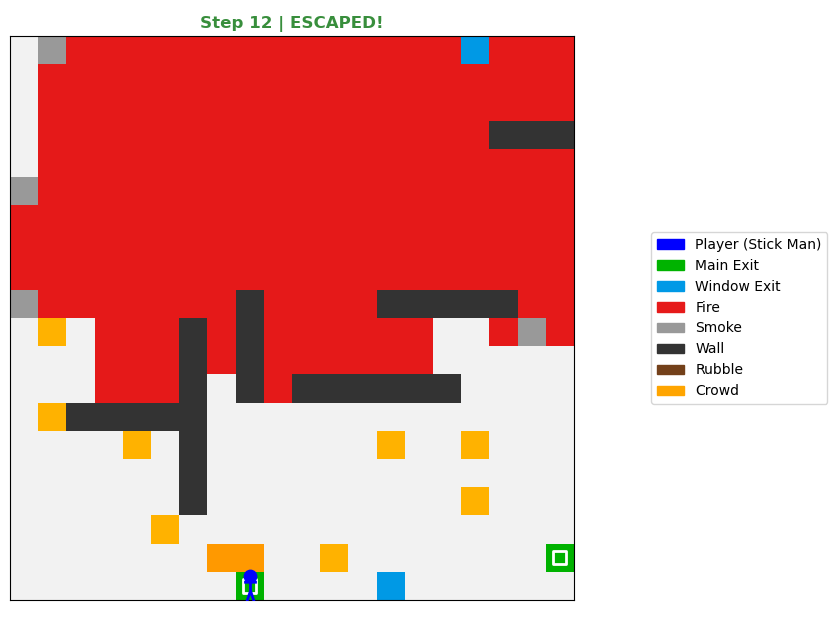

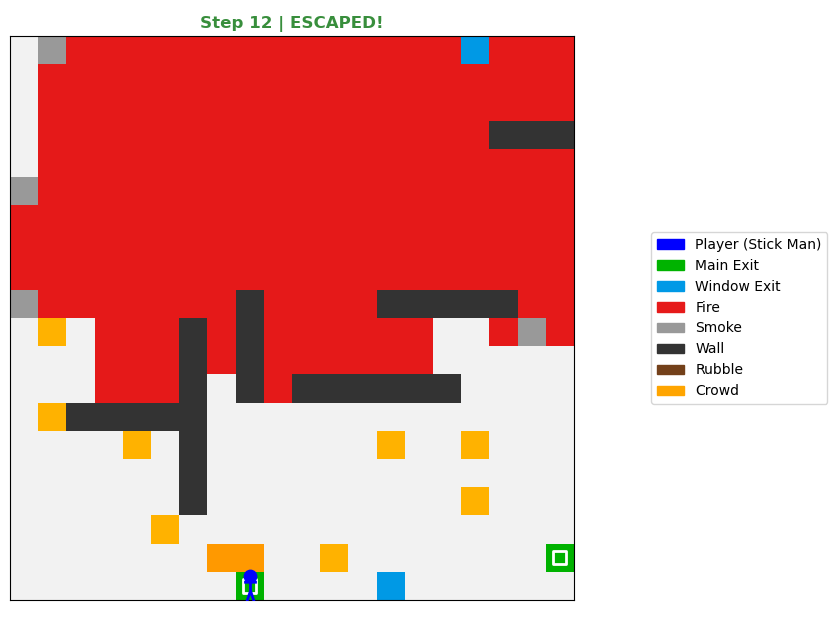

In [5]:
import heapq
import math
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.path as mpath
import time
from collections import deque
from IPython.display import clear_output, display

# --- 1. ROBUST D* LITE LOGIC (WITH DIAGONALS + HEAT BUFFER) ---

def approx(a, b, tol=1e-5):
    if a == float('inf') and b == float('inf'): return True
    if a == float('inf') or b == float('inf'): return False
    return abs(a - b) < tol

class Key:
    def __init__(self, k1, k2):
        self.k1, self.k2 = k1, k2
    def __lt__(self, other):
        if approx(self.k1, other.k1):
            return self.k2 < other.k2
        return self.k1 < other.k1
    def __repr__(self):
        return f"({self.k1:.2f}, {self.k2:.2f})"

class Node:
    def __init__(self, x, y):
        self.x, self.y = x, y
        self.pos = (x, y)
        self.g = float('inf')
        self.rhs = float('inf')
        self.neighbors = []
        self.type = 'EMPTY' 
        self.crowd_density = 0 
        
    def __lt__(self, other):
        return self.pos < other.pos
    def __repr__(self):
        return f"N{self.pos}"

class DStarLite:
    def __init__(self, start, goals, windows, nodes_dict):
        self.start = start 
        self.goals = goals 
        self.windows = windows 
        self.nodes = nodes_dict
        self.km = 0.0
        self.queue = []
        self.in_queue = {} 
        
        # Fire Awareness State
        self.fire_near_main_exits = False
        self.prev_fire_state = False

    def h(self, n):
        return math.hypot(n.x - self.start.x, n.y - self.start.y)

    def c(self, u, v):
        # 1. HARD OBSTACLES (Infinite Cost)
        if u.type == 'FIRE' or v.type == 'FIRE': return float('inf')
        if u.type == 'WALL' or v.type == 'WALL': return float('inf')
        if u.type == 'RUBBLE' or v.type == 'RUBBLE': return float('inf')
        
        # Base Movement Cost
        cost = 1.414 if (u.x != v.x and u.y != v.y) else 1.0
        
        # 2. FIRE PROXIMITY PENALTY (The Fix)
        # Check if the destination node 'v' is touching any FIRE nodes.
        # If yes, add a massive penalty. This creates a "safety buffer".
        near_fire = False
        for n in v.neighbors:
            if n.type == 'FIRE':
                near_fire = True
                break
        
        if near_fire:
            # Huge penalty to discourage walking near fire, but not 'inf' 
            # (so it doesn't crash if that's the ONLY path left).
            cost += 100.0 

        # 3. Soft Obstacles (Smoke)
        if v.type == 'SMOKE': cost += 5.0
        
        # 4. Dynamic Window Preference
        if v in self.windows: 
            if self.fire_near_main_exits:
                cost += 0.0
            else:
                cost += 10.0 

        # 5. Crowd Logic
        if v.type == 'CROWD':
            active_exits = [n for n in (self.goals + self.windows) if n.type != 'RUBBLE']
            if not active_exits:
                dist = float('inf')
            else:
                dist = min([math.hypot(v.x - g.x, v.y - g.y) for g in active_exits])
            
            if dist < 3: cost += 2.0 
            else: cost += 20.0 
                
        return cost

    def calc_key(self, u):
        m = min(u.g, u.rhs)
        return Key(m + self.h(u) + self.km, m)

    def update_vertex(self, u):
        key = self.calc_key(u)
        if not approx(u.g, u.rhs):
            heapq.heappush(self.queue, (key, u))
            self.in_queue[u] = key
        elif u in self.in_queue:
            del self.in_queue[u]

    def compute_shortest_path(self):
        while self.queue:
            k_old, u = self.queue[0]
            k_start = self.calc_key(self.start)
            
            if u not in self.in_queue or (self.in_queue[u].k1 != k_old.k1 or self.in_queue[u].k2 != k_old.k2):
                heapq.heappop(self.queue)
                continue
            
            if k_old < k_start or self.start.rhs > self.start.g:
                heapq.heappop(self.queue)
                if u in self.in_queue: del self.in_queue[u]
                
                k_new = self.calc_key(u)
                
                if k_old < k_new:
                    heapq.heappush(self.queue, (k_new, u))
                    self.in_queue[u] = k_new
                elif u.g > u.rhs:
                    u.g = u.rhs
                    for s in u.neighbors:
                        if s.type != 'RUBBLE':
                             s.rhs = min(s.rhs, self.c(s, u) + u.g)
                        self.update_vertex(s)
                else:
                    g_old = u.g
                    u.g = float('inf')
                    for s in u.neighbors + [u]:
                        if approx(s.rhs, self.c(s, u) + g_old):
                             if s.type != 'RUBBLE' and s not in self.goals and s not in self.windows:
                                s.rhs = float('inf')
                                for sp in s.neighbors:
                                    s.rhs = min(s.rhs, self.c(s, sp) + sp.g)
                             if s.type == 'RUBBLE':
                                 s.rhs = float('inf')
                        self.update_vertex(s)
            else:
                break

    def initialize(self):
        self.km = 0
        self.queue = []
        self.in_queue = {}
        for n in self.nodes.values():
            n.g = float('inf')
            n.rhs = float('inf')
            
        targets = [t for t in (self.goals + self.windows) if t.type != 'RUBBLE']
        for target in targets:
            target.rhs = 0
            key = self.calc_key(target)
            heapq.heappush(self.queue, (key, target))
            self.in_queue[target] = key
            
        self.compute_shortest_path()

    def update_map(self, changed_nodes):
        # 1. Fire Detection near Main Exits
        for u in changed_nodes:
            if u.type == 'FIRE':
                for g in self.goals:
                    dist = math.hypot(u.x - g.x, u.y - g.y)
                    if dist < 6.0: 
                        self.fire_near_main_exits = True
        
        # 2. Window Strategy Switch
        if self.fire_near_main_exits != self.prev_fire_state:
            self.prev_fire_state = self.fire_near_main_exits
            for w in self.windows:
                self.update_vertex(w)
                for n in w.neighbors:
                    if n.type != 'RUBBLE':
                        n.rhs = min(n.rhs, self.c(n, w) + w.g)
                        self.update_vertex(n)

        # 3. Standard D* Lite Update Loop
        # Note: When a node becomes FIRE, its neighbors are updated here.
        # They will call self.c() during update, which now includes the 'near_fire' check.
        for u in changed_nodes:
            if u.type == 'RUBBLE' and (u in self.goals or u in self.windows):
                u.g = float('inf')
                u.rhs = float('inf')
                for s in u.neighbors:
                    self.update_vertex(s)
                self.update_vertex(u)
                continue

            for s in u.neighbors + [u]:
                if s.type != 'RUBBLE':
                    if s not in self.goals and s not in self.windows:
                        s.rhs = float('inf')
                        for sp in s.neighbors:
                             s.rhs = min(s.rhs, self.c(s, sp) + sp.g)
                self.update_vertex(s)
                
        self.compute_shortest_path()

    def move_agent(self):
        if self.start.rhs == float('inf'): return None
        
        best = None
        min_c = float('inf')
        
        for n in self.start.neighbors:
            edge_cost = self.c(self.start, n)
            if edge_cost == float('inf'): continue

            curr_c = edge_cost + n.g
            if curr_c < min_c:
                min_c = curr_c
                best = n
                
        if best and min_c != float('inf'):
            self.km += self.h(best) 
            self.start = best 
            return best
        return None

# --- 2. SIMULATION ENVIRONMENT ---

class Simulation:
    def __init__(self, size=20):
        self.size = size
        self.grid = {}
        self.nodes_list = []
        self.hidden_hazards = set()
        
        # Grid Init
        for x in range(size):
            for y in range(size):
                n = Node(x, y)
                self.grid[(x,y)] = n
                self.nodes_list.append(n)
        
        # 8-Directional Neighbors
        directions = [
            (-1, 0), (1, 0), (0, -1), (0, 1),   # Cardinals
            (-1, -1), (-1, 1), (1, -1), (1, 1)  # Diagonals
        ]
        
        for n in self.nodes_list:
            for dx, dy in directions:
                nx, ny = n.x+dx, n.y+dy
                if (nx, ny) in self.grid:
                    n.neighbors.append(self.grid[(nx, ny)])

        self.start_node = self.grid[(size//2, size//2)]
        
        # Map Gen
        attempts = 0
        while True:
            self.clear_obstacles()
            self.generate_walls()
            self.generate_goals()
            if self.check_connectivity(): break
            attempts += 1
            if attempts > 20: break

        # Crowd Gen
        self.crowd_agents = [] 
        num_people = int((size * size) * 0.15) 
        count = 0
        while count < num_people:
            n = self.grid[(random.randint(0, size-1), random.randint(0, size-1))]
            if n.type == 'EMPTY' and n != self.start_node and n not in self.goals:
                n.type = 'CROWD'
                self.crowd_agents.append({'node': n, 'rational': random.random() < 0.7})
                count += 1

        self.solver = DStarLite(self.start_node, self.goals, self.windows, self.grid)
        self.solver.initialize()
        
        self.steps = 0
        self.escaped = False
        self.trapped = False
        self.trapped_reason = ""
        self.fire_front = []
        self.panic_mode = False 
        
        self.single_source_fire_mode = random.random() < 0.70
        self.has_ignited = False

    def clear_obstacles(self):
        for n in self.nodes_list:
            if n.type == 'WALL' or n.type == 'RUBBLE': n.type = 'EMPTY'
        self.goals = []
        self.windows = []

    def generate_walls(self):
        num_walls = 6
        for _ in range(num_walls):
            wx, wy = random.randint(2, self.size-3), random.randint(2, self.size-3)
            length = random.randint(3, 7)
            dx, dy = random.choice([(0,1), (1,0)])
            for i in range(length):
                tx, ty = wx + dx*i, wy + dy*i
                if (tx, ty) in self.grid:
                    w = self.grid[(tx, ty)]
                    if abs(w.x - self.start_node.x) > 1 or abs(w.y - self.start_node.y) > 1:
                        w.type = 'WALL'

    def generate_goals(self):
        while len(self.goals) < 2:
            g = random.choice([n for n in self.nodes_list if (n.x==0 or n.x==self.size-1 or n.y==0 or n.y==self.size-1)])
            if g.type != 'WALL': self.goals.append(g)
        while len(self.windows) < 2:
            w = random.choice([n for n in self.nodes_list if (n.x==0 or n.x==self.size-1 or n.y==0 or n.y==self.size-1)])
            if w.type != 'WALL' and w not in self.goals: self.windows.append(w)

    def check_connectivity(self):
        q = deque([self.start_node])
        visited = {self.start_node}
        found_exit = False
        while q:
            curr = q.popleft()
            if curr in self.goals or curr in self.windows:
                found_exit = True
                break
            for n in curr.neighbors:
                if n.type != 'WALL' and n.type != 'RUBBLE' and n not in visited:
                    visited.add(n)
                    q.append(n)
        return found_exit

    def ignite_and_spread(self):
        updates = []
        
        should_ignite = False
        if not self.has_ignited:
            if random.random() < 0.15: should_ignite = True
        else:
            if not self.single_source_fire_mode and random.random() < 0.05:
                should_ignite = True

        if should_ignite: 
            rx, ry = random.randint(1, self.size-2), random.randint(1, self.size-2)
            s = self.grid[(rx, ry)]
            if s.type == 'EMPTY' and s != self.start_node:
                s.type = 'FIRE'
                self.fire_front.append(s)
                updates.append(s)
                self.has_ignited = True

        new_fire = []
        spread_chance = random.uniform(0.40, 0.70) 
        
        for f in self.fire_front:
            for n in f.neighbors:
                if n.type != 'FIRE' and n.type != 'WALL' and n.type != 'RUBBLE' and n not in self.goals:
                    if random.random() < spread_chance: 
                        n.type = 'FIRE'
                        new_fire.append(n)
                        updates.append(n)
                        self.crowd_agents = [c for c in self.crowd_agents if c['node'] != n]
                    elif random.random() < 0.80 and n.type == 'EMPTY':
                        n.type = 'SMOKE'
                        updates.append(n)
                        
        self.fire_front.extend(new_fire)
        return updates

    def trigger_collapse(self):
        active_exits = [n for n in (self.goals + self.windows) if n.type != 'RUBBLE']
        
        if len(active_exits) > 1 and random.random() < 0.20: 
            victim = random.choice(active_exits)
            
            fire_nearby = False
            if self.fire_front:
                min_dist = float('inf')
                for f in self.fire_front:
                    d = math.hypot(f.x - victim.x, f.y - victim.y)
                    if d < min_dist: min_dist = d
                    if min_dist <= 5: 
                        fire_nearby = True
                        break
            
            crowd_count = sum(1 for n in victim.neighbors if n.type == 'CROWD')
            crowded = crowd_count >= 3 
            
            if (fire_nearby or crowded) and random.random() < 0.3:
                victim.type = 'RUBBLE'
                self.hidden_hazards.add(victim) 
                return True, victim

        return False, None

    def move_crowds(self):
        updates = []
        random.shuffle(self.crowd_agents)
        all_exits = [e for e in (self.goals + self.windows) if e.type != 'RUBBLE']
        
        for agent in self.crowd_agents:
            curr = agent['node']
            if curr.type == 'FIRE': continue 
            
            valid = [n for n in curr.neighbors if n.type == 'EMPTY' or n in all_exits]
            if not valid: continue

            if self.panic_mode:
                if agent['rational'] and all_exits:
                    target = min(valid, key=lambda n: min([math.hypot(n.x-e.x, n.y-e.y) for e in all_exits]))
                else:
                    target = random.choice(valid)
            else:
                target = random.choice(valid) if valid else None

            if target:
                if target in all_exits:
                    curr.type = 'EMPTY'
                    updates.append(curr)
                    agent['node'] = None 
                elif target.type == 'EMPTY':
                    curr.type = 'EMPTY'
                    target.type = 'CROWD'
                    agent['node'] = target
                    updates.append(curr); updates.append(target)

        self.crowd_agents = [a for a in self.crowd_agents if a['node'] is not None]
        return updates

    def step(self):
        has_fire = len(self.fire_front) > 0
        if has_fire:
            self.panic_mode = True

        if (self.start_node in self.goals or self.start_node in self.windows) and self.start_node.type != 'RUBBLE':
            self.escaped = True
            return

        fire_updates = self.ignite_and_spread()
        crowd_updates = self.move_crowds()
        collapsed, victim_node = self.trigger_collapse()
        
        for n in self.nodes_list: n.crowd_density = 0
        for agent in self.crowd_agents:
            n = agent['node']
            count = sum(1 for nb in n.neighbors if nb.type == 'CROWD')
            n.crowd_density = count

        perception_updates = []
        perception_updates.extend(fire_updates)
        perception_updates.extend(crowd_updates)
        
        discovered_hazards = []
        for hazard in list(self.hidden_hazards):
            dist = math.hypot(self.start_node.x - hazard.x, self.start_node.y - hazard.y)
            if dist <= 3: 
                perception_updates.append(hazard)
                discovered_hazards.append(hazard)
        
        for d in discovered_hazards:
            self.hidden_hazards.remove(d)

        all_updates = list(set(perception_updates))
        if all_updates: 
            self.solver.update_map(all_updates)
        
        if self.panic_mode:
            next_n = self.solver.move_agent()
            if next_n: 
                self.start_node = next_n
            else: 
                self.trapped = True
                fire_nearby = any(n.type == 'FIRE' for n in self.start_node.neighbors)
                rubble_nearby = any(n.type == 'RUBBLE' for n in self.start_node.neighbors)
                if fire_nearby: self.trapped_reason = "Surrounded by Fire"
                elif rubble_nearby: self.trapped_reason = "Exit Collapsed (Rubble)"
                else: self.trapped_reason = "No Path Found (Path Blocked)"
        else:
            pass

        self.steps += 1

# --- 3. IMPROVED VISUALIZATION (STICK FIGURE) ---

def create_stick_figure_marker():
    verts = [
        (0.0, 0.5), 
        (0.0, 0.5), (0.0, -0.2), 
        (-0.3, 0.2), (0.3, 0.2), 
        (0.0, -0.2), (-0.2, -0.8), 
        (0.0, -0.2), (0.2, -0.8), 
    ]
    codes = [
        mpath.Path.MOVETO, 
        mpath.Path.MOVETO, mpath.Path.LINETO, 
        mpath.Path.MOVETO, mpath.Path.LINETO, 
        mpath.Path.MOVETO, mpath.Path.LINETO, 
        mpath.Path.MOVETO, mpath.Path.LINETO, 
    ]
    return mpath.Path(verts, codes)

def run_simulation():
    sim = Simulation(size=20)
    
    fig = plt.figure(figsize=(10, 8))
    gs = fig.add_gridspec(1, 2, width_ratios=[4, 1])
    ax = fig.add_subplot(gs[0])
    ax_legend = fig.add_subplot(gs[1])
    
    print(">>> D* Lite Evacuation Sim v4.6 (With Fire Buffer)")
    print(f">>> Mode: {'Single Fire Source' if sim.single_source_fire_mode else 'Multi-Source Chaos'}")
    
    # Colors
    C_WALL = (0.2, 0.2, 0.2)       
    C_FLOOR = (0.95, 0.95, 0.95)   
    C_FIRE = (0.9, 0.1, 0.1)       
    C_SMOKE = (0.6, 0.6, 0.6)      
    C_RUBBLE = (0.45, 0.25, 0.1)  
    C_GOAL = (0.0, 0.7, 0.0)       
    C_WINDOW = (0.0, 0.6, 0.9)     
    
    stick_marker = create_stick_figure_marker()
    
    patches = [
        mpatches.Patch(color='blue', label='Player (Stick Man)'),
        mpatches.Patch(color=C_GOAL, label='Main Exit'),
        mpatches.Patch(color=C_WINDOW, label='Window Exit'),
        mpatches.Patch(color=C_FIRE, label='Fire'),
        mpatches.Patch(color=C_SMOKE, label='Smoke'),
        mpatches.Patch(color=C_WALL, label='Wall'),
        mpatches.Patch(color=C_RUBBLE, label='Rubble'),
        mpatches.Patch(color='orange', label='Crowd')
    ]

    for _ in range(250): 
        # 1. Build Grid
        rgb_grid = [[C_FLOOR for _ in range(sim.size)] for _ in range(sim.size)]

        for n in sim.nodes_list:
            if n.type == 'WALL': rgb_grid[n.y][n.x] = C_WALL
            elif n.type == 'RUBBLE': rgb_grid[n.y][n.x] = C_RUBBLE
            elif n.type == 'FIRE': rgb_grid[n.y][n.x] = C_FIRE
            elif n.type == 'SMOKE': rgb_grid[n.y][n.x] = C_SMOKE
            elif n.type == 'CROWD':
                d = min(n.crowd_density, 4)
                rgb_grid[n.y][n.x] = (1.0, 0.7 - (d*0.1), 0.0) 

        for g in sim.goals: 
            if g.type != 'RUBBLE': rgb_grid[g.y][g.x] = C_GOAL
            else: rgb_grid[g.y][g.x] = C_RUBBLE 
            
        for w in sim.windows: 
            if w.type != 'RUBBLE': rgb_grid[w.y][w.x] = C_WINDOW
            else: rgb_grid[w.y][w.x] = C_RUBBLE

        # 2. Render
        ax.clear()
        ax.imshow(rgb_grid, origin='lower', interpolation='nearest')
        
        # 3. Agent
        sx, sy = sim.start_node.pos
        ax.scatter(sx, sy+0.35, marker='o', s=80, color='blue', zorder=10) 
        ax.scatter(sx, sy, marker=stick_marker, s=600, color='blue', linewidth=2, zorder=10) 
        
        # 4. Exits
        for g in sim.goals:
            if g.type != 'RUBBLE':
                ax.scatter(g.x, g.y, marker='s', s=100, facecolors='none', edgecolors='white', linewidth=2)
        
        ax.set_xticks([]); ax.set_yticks([])
        ax.grid(False)
        
        # Status Logic
        if sim.panic_mode:
            status_text = "PANIC! EVACUATING"
            t_color = '#D32F2F'
            if sim.solver.fire_near_main_exits:
                status_text += " (EXITS BLOCKED -> USING WINDOWS)"
        else:
            status_text = "CALM (No Fire Detected)"
            t_color = '#1976D2' 

        if sim.trapped: 
            status_text = f"TRAPPED: {sim.trapped_reason}"
            t_color = 'black'
        elif sim.escaped:
            status_text = "ESCAPED!"
            t_color = '#388E3C' 

        ax.set_title(f"Step {sim.steps} | {status_text}", fontsize=12, fontweight='bold', color=t_color)
        
        ax_legend.clear()
        ax_legend.axis('off')
        ax_legend.legend(handles=patches, loc='center left', fontsize=10)
        
        display(fig)
        clear_output(wait=True)
        
        if sim.escaped or sim.trapped:
            display(fig) 
            break
            
        sim.step()
        time.sleep(0.1) 

if __name__ == "__main__":
    run_simulation()